In [87]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from wordcloud import WordCloud

# nltk.download('all')
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import words, stopwords, wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression

import time

# suppress deprecation warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# import python helper functions
from helpers import *

# metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix

import pickle

# word embedding
from gensim.models import word2vec

seed = 42

## Twitter sentiment analysis

In [88]:
directory = "F:\Ingenieur_IA\P7_sentiment_analysis"
data = pd.read_csv("../data/tweets.csv", delimiter=",", encoding = "ISO-8859-1", header=None)

In [89]:
data = data[[0, 5]]
data = data.rename(columns={0: "target", 5: "tweet"})
data

,target,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


In [90]:
print("0 represents negative reviews, 4 represents positive reviews")
data.target.value_counts()

0 represents negative reviews, 4 represents positive reviews


0    800000
4    800000
Name: target, dtype: int64

Text(0.5, 1.0, 'Distribution of positive (4) and negative (0) sentiment')

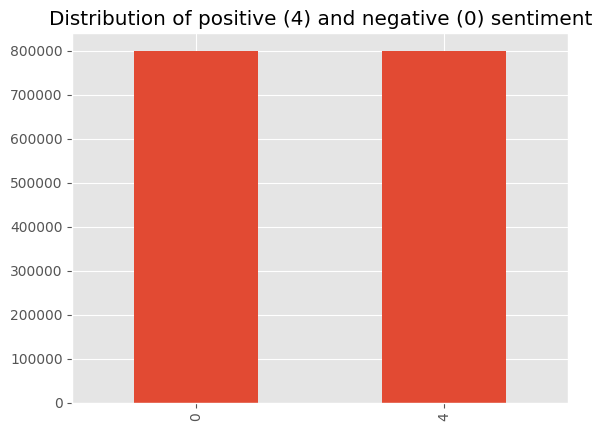

In [91]:
chart = data.target.value_counts().plot(kind="bar")
chart.set_title("Distribution of positive (4) and negative (0) sentiment")

In [92]:
sample_df = pd.DataFrame()

for target in [0,4]:
    target_df = data[data["target"] == target].sample(50000, random_state=42)
    sample_df = sample_df.append(target_df, ignore_index=True)

In [93]:
sample_df["clean_tweet"] = sample_df["tweet"].apply(lambda row : text_cleaner(row)).apply(lambda x : " ".join(x))

### WordCloud for positive tweets

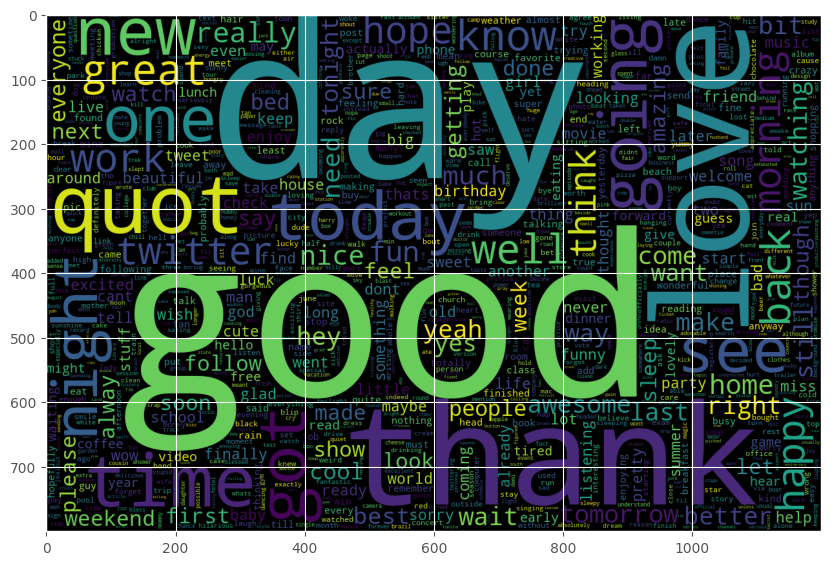

In [94]:
positive_tweets = sample_df[sample_df["target"]==4]["clean_tweet"]

plt.figure(figsize=(10,8))
wordcloud = WordCloud(max_words=1000, width=1200, height=800,
                        collocations=False).generate(" ".join(positive_tweets))
plt.imshow(wordcloud)

### WordCloud for negative tweets

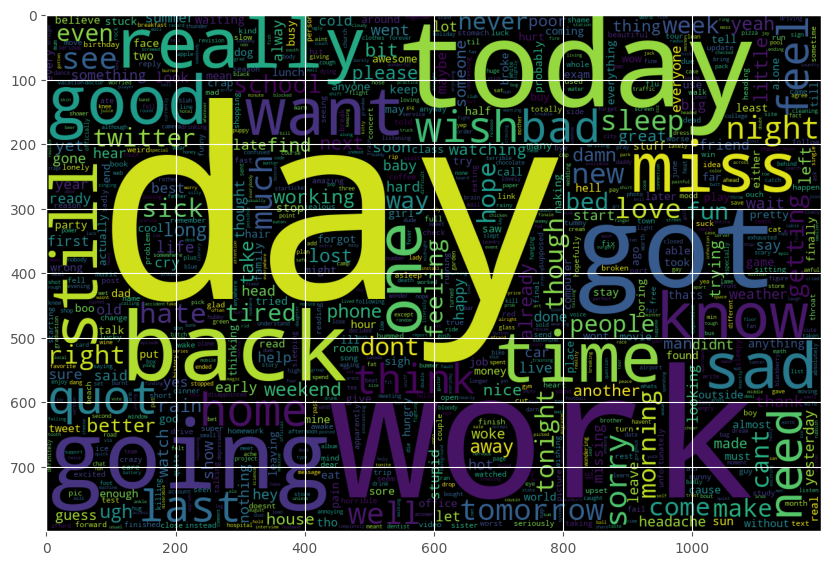

In [95]:
negative_tweets = sample_df[sample_df["target"]==0]["clean_tweet"]

plt.figure(figsize=(10,8))
wordcloud = WordCloud(max_words=1000, width=1200, height=800,
                        collocations=False).generate(" ".join(negative_tweets))
plt.imshow(wordcloud)

## Baseline: Logistic Regression with TF-IDF vectorizer

In [96]:
X = sample_df["clean_tweet"]
y = np.array(sample_df["target"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

print("Splitting done.")
print("Shape of training set: " + str(X_train.shape))
print("Shape of test shape: " + str(X_test.shape))
print("Count of training target values: " + str(np.unique(y_train, return_counts=True)))
print("Count of test target values: " + str(np.unique(y_test, return_counts=True)))

Splitting done.
Shape of training set: (70000,)
Shape of test shape: (30000,)
Count of training target values: (array([0, 4], dtype=int64), array([34945, 35055], dtype=int64))
Count of test target values: (array([0, 4], dtype=int64), array([15055, 14945], dtype=int64))


Time to train vectorizer and transform training text: 4.62s
Model evaluation:
              precision    recall  f1-score   support

           0       0.75      0.70      0.73     15055
           4       0.72      0.77      0.74     14945

    accuracy                           0.73     30000
   macro avg       0.74      0.73      0.73     30000
weighted avg       0.74      0.73      0.73     30000



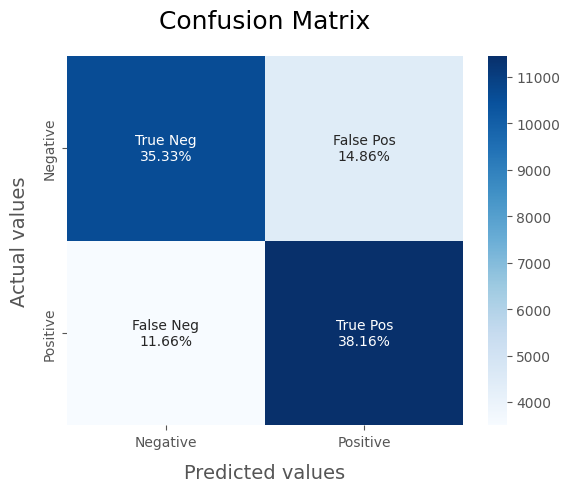

In [97]:
classification_model = LogisticRegression(max_iter=1000, n_jobs=-1)
tfidfconverter = TfidfVectorizer(max_features=500000, min_df=5, max_df=0.7, ngram_range=(1,2))

tfidfconverter.fit(X_train)

start = time.time()

# model = Pipeline([ ("vectorizer", tfidfconverter),
#                    ("classifier", classification_model)])

X_train = tfidfconverter.transform(X_train)
X_test = tfidfconverter.transform(X_test)

classification_model.fit(X_train, y_train)

end = time.time()

predictions = classification_model.predict(X_test)

print('Time to train vectorizer and transform training text: %0.2fs' % (end - start))
print('Model evaluation:')
model_Evaluate(classification_model, X_test, y_test)

In [98]:
print("Number of positive predictions: " + str(predictions.tolist().count(0)))
print("Number of negative predictions: " + str(predictions.tolist().count(4)))

Number of positive predictions: 14095
Number of negative predictions: 15905


In [13]:
file = open('tfidf_vectoriser.pickle', 'wb')
pickle.dump(tfidfconverter, file)
file.close

file = open('Sentiment-LR.pickle', 'wb')
pickle.dump(classification_model, file)
file.close()

In [22]:
predict(["I love twitter", "I hate twitter", "I'm in an excellent mood", "This is terrible news"])

,text,sentiment
0,I love twitter,Positive
1,I hate twitter,Negative
2,I'm in an excellent mood,Positive
3,This is terrible news,Negative


## Deep learning with Keras

In [70]:
from keras.preprocessing.text import one_hot
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, Conv1D, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [55]:
X = np.array(sample_df["clean_tweet"])
y = np.array(sample_df.target.map({0:0, 4:1}))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [56]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [57]:
# make our X_train and X_test vectors of the same size (100)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

### GloVe

Use GloVe embeddings to create our feature matrix. We load GloVe word embeddings and create a dictionary that will contain words as keys and their corresponding embedding list as values.

In [58]:
# Word embedding with GloVe pre-trained on 2 billion tweets from Stanford
# https://nlp.stanford.edu/projects/glove/

embeddings_dictionary = dict()
glove_file = open('../data/glove.twitter.27B/glove.twitter.27B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

Finally, we create an embedding matrix where each row number will correspond to the index of the word in the corpus. The Matrix will have 100 columns where each column will contain the GloVe word embedding for the words in our corpus.

In [59]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [60]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.15967999, -0.36965999,  0.23761   , ...,  0.14169   ,
        -0.13463999, -0.602     ],
       [ 0.091552  ,  0.093336  , -0.028113  , ...,  0.33173001,
        -0.087436  , -0.55506003],
       ...,
       [-0.17651001,  0.082075  , -0.79220998, ...,  0.035903  ,
         0.45423001,  0.064459  ],
       [-0.14449   , -1.06910002, -0.77305001, ...,  0.41150999,
        -0.25863001, -0.54111999],
       [-0.55975002, -0.17293   ,  0.19922   , ...,  0.29581001,
        -0.98425001,  0.29152   ]])

### fasttext

In [ ]:
## try also with fasttext
## https://fasttext.cc/docs/en/english-vectors.html
## https://pypi.org/project/fasttext/

### Simple neural network

In [61]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False) # trainable false because we use GloVe and do not train our own embeddings
model.add(embedding_layer) # input 100, output 100 

model.add(Flatten()) # necessary to connect our embedding layer to densely connected layer
model.add(Dense(1, activation='sigmoid'))

In [62]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          1337000   
                                                                 
 flatten_1 (Flatten)         (None, 10000)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 10001     
                                                                 
Total params: 1,347,001
Trainable params: 10,001
Non-trainable params: 1,337,000
_________________________________________________________________
None


In [63]:
history = model.fit(X_train, 
                    y_train, 
                    batch_size=128, 
                    epochs=3, 
                    verbose=1, 
                    validation_split=0.2) # 20% of the training data is used to find the training accuracy of the algorithm  

Epoch 1/3
500/500 [==============================] - 6s 10ms/step - loss: 0.5963 - acc: 0.6826 - val_loss: 0.5779 - val_acc: 0.6965
Epoch 2/3
500/500 [==============================] - 5s 11ms/step - loss: 0.5676 - acc: 0.7055 - val_loss: 0.5724 - val_acc: 0.6995
Epoch 3/3
500/500 [==============================] - 5s 10ms/step - loss: 0.5622 - acc: 0.7096 - val_loss: 0.5716 - val_acc: 0.6997


In [64]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test score:", score[0])
print("Test accuracy:", score[1])

625/625 [==============================] - 2s 3ms/step - loss: 0.5695 - acc: 0.7038
Test score: 0.5695496797561646
Test accuracy: 0.7038000226020813


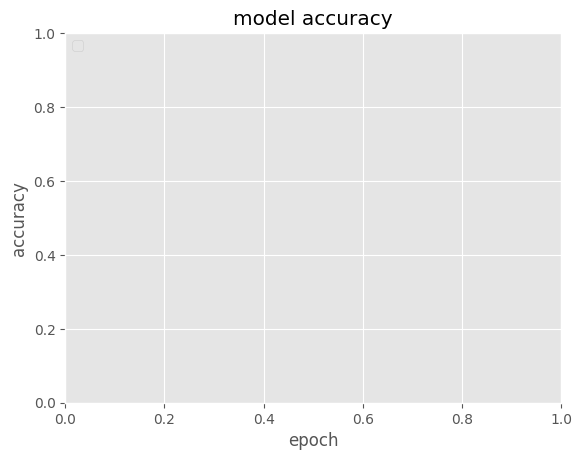

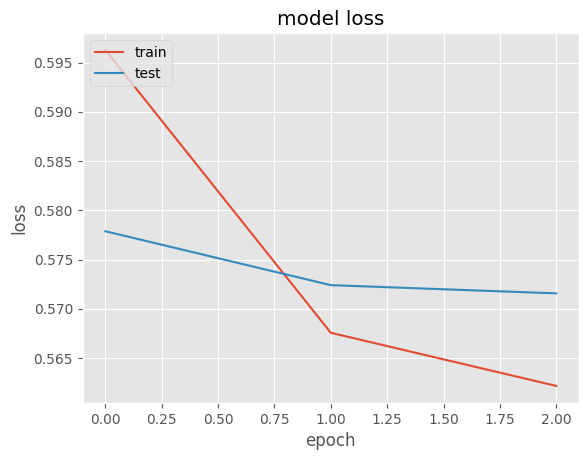

In [65]:
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

### CNN

In [66]:
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          1337000   
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,401,257
Trainable params: 64,257
Non-trainable params: 1,337,000
_________________________________________________________________
None


In [67]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
500/500 [==============================] - 179s 357ms/step - loss: 0.5574 - acc: 0.7075 - val_loss: 0.5477 - val_acc: 0.7129
Epoch 2/6
500/500 [==============================] - 179s 358ms/step - loss: 0.5134 - acc: 0.7412 - val_loss: 0.5433 - val_acc: 0.7173
Epoch 3/6
500/500 [==============================] - 177s 353ms/step - loss: 0.4840 - acc: 0.7636 - val_loss: 0.5434 - val_acc: 0.7204
Epoch 4/6
500/500 [==============================] - 177s 353ms/step - loss: 0.4547 - acc: 0.7819 - val_loss: 0.5527 - val_acc: 0.7174
Epoch 5/6
500/500 [==============================] - 178s 356ms/step - loss: 0.4235 - acc: 0.8035 - val_loss: 0.5687 - val_acc: 0.7091
Epoch 6/6
625/625 [==============================] - 25s 40ms/step - loss: 0.5768 - acc: 0.7150


In [68]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5768282413482666
Test Accuracy: 0.7150499820709229


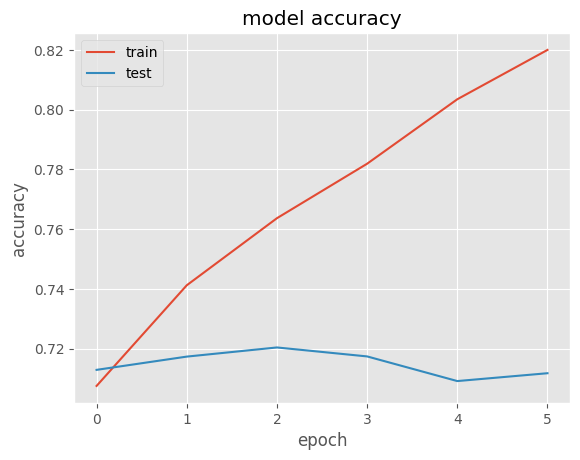

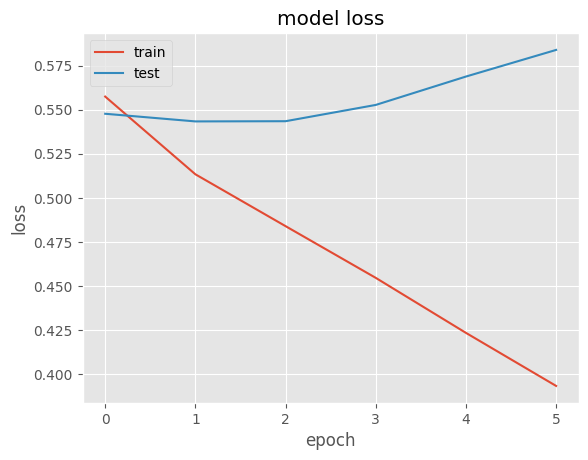

In [69]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

## Deep learning with Keras and an LSTM layer

In [71]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 100)          1337000   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,454,377
Trainable params: 117,377
Non-trainable params: 1,337,000
_________________________________________________________________
None


In [72]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
500/500 [==============================] - 508s 1s/step - loss: 0.6932 - acc: 0.5013 - val_loss: 0.6931 - val_acc: 0.5044
Epoch 2/6
500/500 [==============================] - 502s 1s/step - loss: 0.6932 - acc: 0.5006 - val_loss: 0.6932 - val_acc: 0.4956
Epoch 3/6
500/500 [==============================] - 489s 978ms/step - loss: 0.6932 - acc: 0.5005 - val_loss: 0.6931 - val_acc: 0.5044
Epoch 4/6
500/500 [==============================] - 481s 962ms/step - loss: 0.6932 - acc: 0.5021 - val_loss: 0.6932 - val_acc: 0.4956
Epoch 5/6
500/500 [==============================] - 483s 965ms/step - loss: 0.6932 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5044
Epoch 6/6
625/625 [==============================] - 81s 129ms/step - loss: 0.6932 - acc: 0.4983


In [73]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.6931572556495667
Test Accuracy: 0.49825000762939453


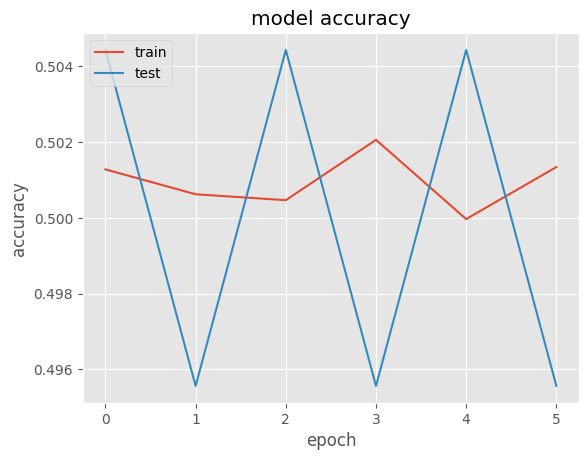

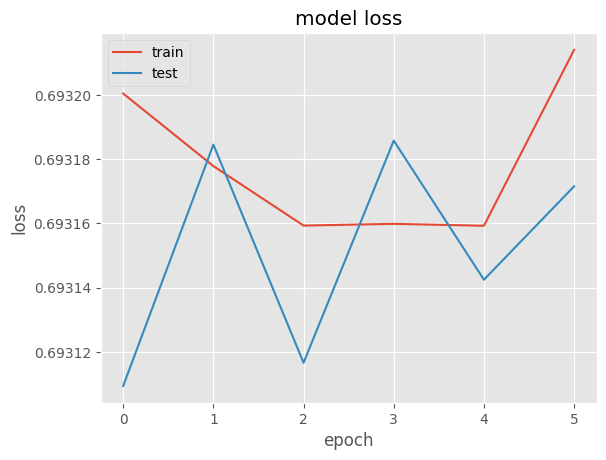

In [74]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

### word2vec

In [42]:
sample_df["clean_tweet_tokens"] = sample_df["tweet"].apply(lambda row : text_cleaner(row))

In [57]:
nlp = word2vec.Word2Vec(sample_df.clean_tweet_tokens, 
                        window=8, 
                        min_count=1, 
                        sg=1)

In [59]:
print("Corpus count: " + str(nlp.corpus_count))
print("Total train time: " + str(nlp.total_train_time))

Corpus count: 20000
Total train time: 1.5648121879976316


In [55]:
nlp.wv.most_similar('great')

[('late', 0.9894574880599976),
 ('well', 0.9884435534477234),
 ('tonight', 0.9882295727729797),
 ('went', 0.9878157377243042),
 ('going', 0.9876714944839478),
 ('today', 0.9863311648368835),
 ('done', 0.9862711429595947),
 ('everyone', 0.9848471879959106),
 ('time', 0.9845932126045227),
 ('party', 0.9845609068870544)]

In [60]:
emb_df = (
    pd.DataFrame(
        [nlp.wv.get_vector(str(n)) for n in nlp.wv.key_to_index],
        index = nlp.wv.key_to_index
    )
)
print(emb_df.shape)
emb_df.head()

(7189, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
good,-0.090628,0.378726,-0.004340,0.093229,0.200997,-0.231282,0.027652,0.627887,-0.257553,-0.053280,...,0.444004,0.238272,-0.011097,-0.017259,0.448977,0.052664,0.018968,-0.154158,0.002780,-0.127179
like,-0.081067,0.354675,0.124770,-0.063853,0.204946,-0.282601,-0.004835,0.516562,-0.208809,-0.099316,...,0.317408,0.269311,-0.024547,-0.029442,0.452688,0.128892,0.137179,-0.191957,0.006121,-0.171824
work,-0.039446,0.408584,-0.083372,0.109344,0.327119,-0.206237,-0.030789,0.677891,-0.279380,0.055858,...,0.273550,0.244044,0.118260,0.014604,0.457240,0.079809,0.089761,-0.033205,0.124465,-0.151650
time,-0.062016,0.425859,-0.004225,0.051638,0.277107,-0.271337,0.067672,0.648728,-0.231290,-0.058896,...,0.363764,0.235364,-0.002314,0.008388,0.477060,0.080977,0.082224,-0.144424,0.049605,-0.174150
today,-0.071706,0.361001,0.017391,0.041448,0.254304,-0.223655,-0.000195,0.589503,-0.220170,0.039085,...,0.288706,0.227328,0.044483,-0.001913,0.455048,0.057856,0.150539,-0.119872,0.070308,-0.113723


[]

<Figure size 640x480 with 0 Axes>

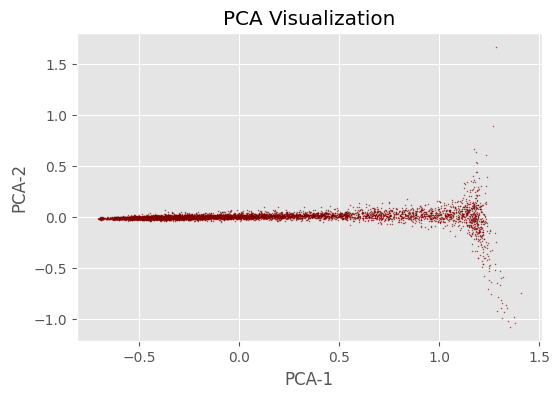

In [67]:
pca = PCA(n_components=2, random_state=7)
pca_mdl = pca.fit_transform(emb_df)

emb_df_PCA = (
    pd.DataFrame(
        pca_mdl,
        columns=['x','y'],
        index = emb_df.index
    )
)

plt.clf()
fig = plt.figure(figsize=(6,4))

plt.scatter(
    x = emb_df_PCA['x'],
    y = emb_df_PCA['y'],
    s = 0.4,
    color = 'maroon',
    alpha = 0.5
)

plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.title('PCA Visualization')
plt.plot()